In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
import os
import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [2]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

if os.path.isfile('pretrained_embeds/glove.6B/glove.6B.50d_w2v.txt'):
    glove_model = KeyedVectors.load_word2vec_format("pretrained_embeds/glove.6B/glove.6B.50d_w2v.txt", binary=False)
else:
    glove2word2vec(glove_input_file="pretrained_embeds/glove.6B/glove.6B.50d.txt", word2vec_output_file="pretrained_embeds/glove.6B/glove.6B.50d_w2v.txt")
    glove_model = KeyedVectors.load_word2vec_format("pretrained_embeds/glove.6B/glove.6B.50d_w2v.txt", binary=False)

def get_embed(word):
    # Case folding
    word = word.lower()
    try:
        return (glove_model.get_vector(word))
    except:
        return (glove_model.get_vector('<unk>'))

In [3]:
data_df = pd.read_pickle("data_df_final.pkl")
data = data_df[data_df['source_article']!='NA'][['source_article', 'category']]
data.sample(frac=1).head()

,source_article,category
3255,Sara Ali Khan sends ‘thank you’ notes to papar...,entertainment
708,MIT researchers are training a robot arm to pl...,technology
679,Google Maps’ ETA sharing feature hits iOS\nIf ...,technology
392,Apple’s App Store revenue nearly double that o...,technology
4786,‘I’ve figured him out. He is a coward’: Rahul ...,politics


In [4]:
category2id = {}
count = 0

for c in set(data['category'].tolist()):
    category2id[c] = count
    count += 1

l = ['1']*7
for k,v in category2id.items():
    l[v] = k
    
print(category2id)

{'automobile': 1, 'technology': 0, 'business': 2, 'science': 5, 'sports': 4, 'politics': 3, 'entertainment': 6}


In [5]:
stop = stopwords.words('english') + list(string.punctuation)

x = []
y = []

for index, row in data.iterrows():
    article = row['source_article']
    article = article.lower()
    article = nltk.word_tokenize(article)
    article = [get_embed(i) for i in article if i not in stop]
    article = np.array(article)
    article = article.mean(axis=0)
    x.append(article)
    
    y.append(category2id[row['category']])

# Train-Test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [6]:
def display_cm(cm):
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.xticks(np.arange(len(l)), l, rotation=45)
    plt.yticks(np.arange(len(l)), l)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.show()

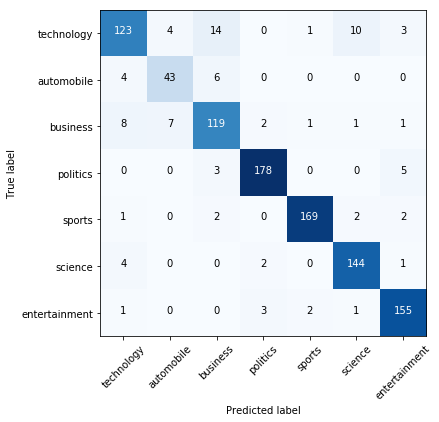

Accuracy for SVM: 91.0958904109589


In [7]:
clf = svm.SVC(C=100, gamma='scale')
clf.fit(x_train, y_train)
pred_y = clf.predict(x_test)
cm = confusion_matrix(y_test, pred_y)
display_cm(cm)
print('Accuracy for SVM: ' + str(clf.score(x_test, y_test)* 100))

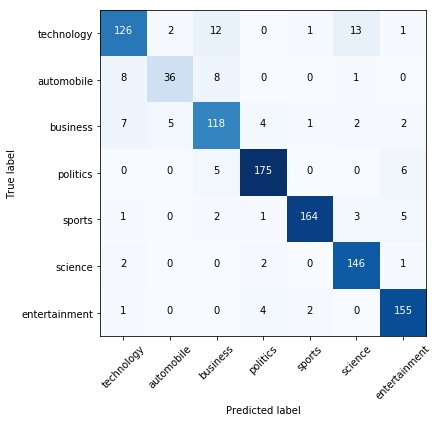

Accuracy for Logistic Regression: 90.01956947162427


In [8]:
clf = LogisticRegression(random_state=0)
clf.fit(x_train, y_train)

pred_y = clf.predict(x_test)
cm = confusion_matrix(y_test, pred_y)
display_cm(cm)
print('Accuracy for Logistic Regression: ' + str(clf.score(x_test, y_test)* 100))